# Text Classification
## Part I: Data Exploration

### About the Dataset
Hello! In this notebook, we'll look to classify emotions based off of text found in a corresponding tweet! This was taken from a dataset from Kaggle.com, and can be found [here:](https://www.kaggle.com/datasets/pashupatigupta/emotion-detection-from-text?resource=download)

https://www.kaggle.com/datasets/pashupatigupta/emotion-detection-from-text?resource=download

In [2]:
import pandas as pd

df = pd.read_csv('tweet_emotions.csv')
print(df.head()) #take a look at how the csv is organized
print("\n", df.shape)

#attribute counts
emo_counts = df['sentiment'].value_counts()
print("\n", emo_counts)

     tweet_id   sentiment                                            content
0  1956967341       empty  @tiffanylue i know  i was listenin to bad habi...
1  1956967666     sadness  Layin n bed with a headache  ughhhh...waitin o...
2  1956967696     sadness                Funeral ceremony...gloomy friday...
3  1956967789  enthusiasm               wants to hang out with friends SOON!
4  1956968416     neutral  @dannycastillo We want to trade with someone w...

 (40000, 3)

 neutral       8638
worry         8459
happiness     5209
sadness       5165
love          3842
surprise      2187
fun           1776
relief        1526
hate          1323
empty          827
enthusiasm     759
boredom        179
anger          110
Name: sentiment, dtype: int64


We've got a big dataset here! But before we do anything else, I'd like to tell you a little bit about the dataset we've got here.
This will be a multi-class classification, as the dataset pulls tweets that have the following emotional implications:
- Neutral
- Worry
- Happiness
- Sadness
- Love
- Surprise
- Fun
- Relief
- Hate
- Empty
- Enthusiasm
- Boredom
- Anger

Due to the size of the dataset itself, and the similarity some of these emotions have to one another, I've opted to make some alterations to the dataset to make our classification a bit more manageable.

In [3]:
#remove a TON of rows based on attribute
attributes_remove = ['neutral', 'surprise', 'fun', 'relief', 'hate', 'empty', 'enthusiasm', 'boredom', 'anger']
df_filtered = df[~df['sentiment'].isin(attributes_remove)]
df_filtered.to_csv('tweets_filtered.csv', index = False)

What we've done to the dataset now is 'cleaned' it. Looking at the original dataset we have a lot of other emotional attributes that are pretty miniscule, so I fear that the models we make won't pick up on classifying those attributes due to a drastically smaller sample size. Addtionally, I've also removed the 'neutral' section because I feel like that doesn't really show much of anything, and would more than likely trip up our algorithms later on. Let's take a look at our cleaned dataset now:

In [4]:
print(df_filtered.head()) #take a look at how the csv is organized
print("\n", df_filtered.shape)

#attribute counts
emo_counts_filtered = df_filtered['sentiment'].value_counts()
print("\n", emo_counts_filtered)

#encode target classes
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
df_filtered['sentiment'] = le.fit_transform(df_filtered['sentiment'])
emotion_labels = dict(zip(le.classes_, le.transform(le.classes_)))
print(emotion_labels)

     tweet_id sentiment                                            content
1  1956967666   sadness  Layin n bed with a headache  ughhhh...waitin o...
2  1956967696   sadness                Funeral ceremony...gloomy friday...
5  1956968477     worry  Re-pinging @ghostridah14: why didn't you go to...
6  1956968487   sadness  I should be sleep, but im not! thinking about ...
7  1956968636     worry               Hmmm. http://www.djhero.com/ is down

 (22675, 3)

 worry        8459
happiness    5209
sadness      5165
love         3842
Name: sentiment, dtype: int64
{'happiness': 0, 'love': 1, 'sadness': 2, 'worry': 3}


/tmp/ipykernel_130136/1655245909.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['sentiment'] = le.fit_transform(df_filtered['sentiment'])


Much more manageable. 
Now we'll do some text preprocessing, then we'll create a test/train split and create some introductory graphs before moving on to training and testing our machine learning models.
(Also - Keep in mind the emotional mappings: Happy = 0, Love = 1, Sad = 2 and Worry = 3)

In [5]:
#preprocess
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
def preprocess(text):
    stop_words = set(stopwords.words('english'))
    words = word_tokenize(text)
    processed = [word for word in words if word not in stop_words or word.isupper()]
    return ' '.join(processed)

df_filtered['content'] = df_filtered['content'].apply(preprocess)
df_filtered.to_csv('tweets_preprocessed.csv', index = False)

#I forgot to do this earlier - need to get rid of NaN values
df_processed = pd.read_csv('tweets_preprocessed.csv')
df_processed = df_processed.dropna(subset=['content'])

/tmp/ipykernel_130136/2200464861.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['content'] = df_filtered['content'].apply(preprocess)


What happens in the codeblock above is that I removed all the stopwords from the tweet content, while preserving anything that is in all caps, as I beleive some kind of emotion can be gleamed from typing things out LIKE THIS. I dunno. It looks loud to me, and that might elicit.. something?

Onto the target class graphs.

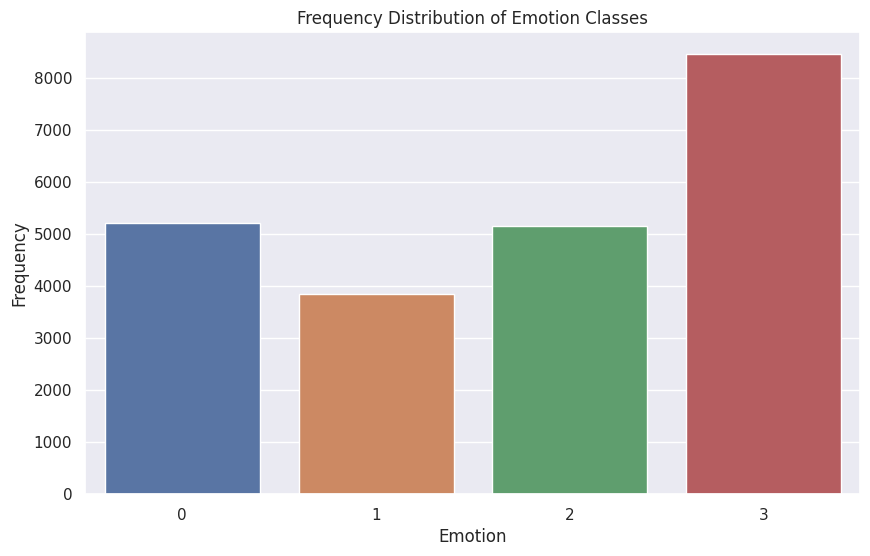

In [6]:
import seaborn as sb
import matplotlib.pyplot as plt

sb.set(style = "darkgrid")
plt.figure(figsize=(10, 6))
ax =sb.countplot(x='sentiment', data = df_processed)
ax.set_xticklabels(emotion_labels.values())
ax.set_title('Frequency Distribution of Emotion Classes')
ax.set_xlabel('Emotion')
ax.set_ylabel('Frequency')

plt.show()

And now, we'll generate that train/test split and conclude our big data processing/exploration/explanation section.

Just to be clear - the goal of these models is to accurately predict what emotion a tweet's text content is based on the four targets we've been toying with up until now, those being 0 - happiness, 1 - love, 2 - sadness and 3 - worry.

In [7]:
from sklearn.model_selection import train_test_split

#y = target = sentiment, or what we want to predict.
x = df_processed.content
y = df_processed.sentiment
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size= 0.2, random_state= 1234)

#peeking at our x and y
print(x.head())
y[:10]

0      Layin n bed headache ughhhh ... waitin call ...
1               Funeral ceremony ... gloomy friday ...
2    Re-pinging @ ghostridah14 : n't go prom ? BC b...
3    I sleep , im ! thinking old friend I want . 's...
4                      Hmmm . http : //www.djhero.com/
Name: content, dtype: object


/tmp/ipykernel_130136/565712513.py:10: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y[:10]


0    2
1    2
2    3
3    2
4    3
5    2
6    2
7    3
8    2
9    2
Name: sentiment, dtype: int64

# Part II - Machine Learning
## Section I - Naive Bayes Model


In [8]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

vectorizor = TfidfVectorizer()
x_train = vectorizor.fit_transform(x_train)
x_test = vectorizor.transform(x_test)

#create the multinomial NB model
nb_model = MultinomialNB()
nb_model.fit(x_train, y_train)

#make predictions on test set
y_prediction = nb_model.predict(x_test)

#stats
print("Accuracy:", accuracy_score(y_test, y_prediction))
print("\nClassification Report:\n", classification_report(y_test, y_prediction))
print("\nConfusion Matrix\n", confusion_matrix(y_test, y_prediction))

Accuracy: 0.4604189636163175

Classification Report:
               precision    recall  f1-score   support

           0       0.57      0.27      0.37      1034
           1       0.70      0.18      0.29       728
           2       0.45      0.04      0.07      1029
           3       0.43      0.94      0.59      1744

    accuracy                           0.46      4535
   macro avg       0.54      0.36      0.33      4535
weighted avg       0.51      0.46      0.37      4535


Confusion Matrix
 [[ 279   39    6  710]
 [ 132  131    9  456]
 [  19    3   40  967]
 [  58   14   34 1638]]


## Section II - Logistic Regression

In [9]:
from sklearn.linear_model._logistic import LogisticRegression

logreg = LogisticRegression(multi_class='multinomial', solver='lbfgs')
logreg.fit(x_train, y_train)

y_prediction_lgrg = logreg.predict(x_test)

#stats
print("Accuracy:", accuracy_score(y_test, y_prediction_lgrg))
print("\nClassification Report:\n", classification_report(y_test, y_prediction_lgrg))
print("\nConfusion Matrix\n", confusion_matrix(y_test, y_prediction_lgrg))

Accuracy: 0.5140022050716648

Classification Report:
               precision    recall  f1-score   support

           0       0.52      0.53      0.53      1034
           1       0.57      0.40      0.47       728
           2       0.45      0.31      0.36      1029
           3       0.52      0.68      0.59      1744

    accuracy                           0.51      4535
   macro avg       0.51      0.48      0.49      4535
weighted avg       0.51      0.51      0.50      4535


Confusion Matrix
 [[ 546  126   56  306]
 [ 209  291   42  186]
 [  84   34  316  595]
 [ 207   63  296 1178]]


/home/jacko/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


(Just as a note - we have a bit of a warning for max_iterations, so I'm gonna play around w/ it and see if anything happens.)  

In [10]:
logreg_MAX = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=1000)
logreg_MAX.fit(x_train, y_train)

y_prediction_lgrg_MAX = logreg_MAX.predict(x_test)

#stats
print("Accuracy:", accuracy_score(y_test, y_prediction_lgrg_MAX))
print("\nClassification Report:\n", classification_report(y_test, y_prediction_lgrg_MAX))
print("\nConfusion Matrix\n", confusion_matrix(y_test, y_prediction_lgrg_MAX))

Accuracy: 0.5140022050716648

Classification Report:
               precision    recall  f1-score   support

           0       0.52      0.53      0.52      1034
           1       0.57      0.40      0.47       728
           2       0.45      0.31      0.36      1029
           3       0.52      0.68      0.59      1744

    accuracy                           0.51      4535
   macro avg       0.51      0.48      0.49      4535
weighted avg       0.51      0.51      0.50      4535


Confusion Matrix
 [[ 544  127   57  306]
 [ 207  290   42  189]
 [  83   33  317  596]
 [ 206   63  295 1180]]


(Hooray for marginal improvements!)

## Section III - Neural Networks

In [11]:
from sklearn.neural_network import MLPClassifier

#max_iter has to be low due to dataset. can't iterate 20,000+ datapoints 200 times. (though i'd like to)
nn = MLPClassifier(hidden_layer_sizes=(1000,4), solver="adam", max_iter= 1, random_state=1234)
nn.fit(x_train, y_train)

nn_pred = nn.predict(x_test)
#stats
print("Accuracy:", accuracy_score(y_test, nn_pred))
print("\nClassification Report:\n", classification_report(y_test, nn_pred))
print("\nConfusion Matrix\n", confusion_matrix(y_test, nn_pred))

Accuracy: 0.43263506063947077

Classification Report:
               precision    recall  f1-score   support

           0       0.59      0.05      0.08      1034
           1       0.56      0.37      0.45       728
           2       0.15      0.09      0.11      1029
           3       0.46      0.89      0.61      1744

    accuracy                           0.43      4535
   macro avg       0.44      0.35      0.31      4535
weighted avg       0.43      0.43      0.35      4535


Confusion Matrix
 [[  47  143  223  621]
 [  10  272  136  310]
 [  11   32   90  896]
 [  12   43  136 1553]]


/home/jacko/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


# Part III - An Analysis
Our best performing model was the logistic regression that was tuned ever-so slightly to get it's max iterations up, putting up an accuracy of around 51.4%. (It was a marginal increase, about a 0.1% improvement from the standard logistic regression model we used.) Naive Bayes performed poorly with an accuracy of 46%.

What I found interesting was the neural network model, as it kept crashing my python kernel as I was meddling around with the model. (Whoops.) Usually, the more I tinkered, the worse the accuracy was. The best accuracy was around 50% and I genuinely cannot remember the configuration I tried. (I tried many.) However, I tried adhering to the following principles:

- Hidden layer size should be set like this (some range within the number of features, number of targets)
- lbfgs had a lot of convergence issues, so I switched to adam (the default, but slower solver that takes care of larger datasets easier) and had a low max_iter value. (Can't compute ALL this data more than once honestly. Though I'd like to try that later.)
- The max iterations changed a lot because it ~~bricked my laptop so many times~~ took a while to compute all the data normally, doing it OVER AND OVER AND OVER would be uhhh inadvisable for my old, clunky hardware.

So after two or so minutes of computation, my neural network had an incredible accuracy of 43%, offering none of the accuracy and taking all of the time. I really do like playing around with the MLPClassifer object parameters, just as a hopeless trial and error to see what works and what doesn't.